In [ ]:
# 1) Import et chargement du tableau d'analyse
import pandas as pd

# Chemin relatif depuis le notebook vers le CSV nettoyé
csv_path = '../data/analyse_lancers_table.csv'
df = pd.read_csv(csv_path)

# 2) Aperçu rapide pour contrôle
print("Avant nettoyage :")
print(f"  Shape : {df.shape}")
print("  Valeurs manquantes par colonne:")
print(df.isna().sum())

# 3) Suppression des essais sans point d’impact valide
df = df.dropna(subset=['DistanceImpact', 'error_to_target'])

# 4) Vérification après nettoyage
print("\nAprès suppression des NaN :")
print(f"  Shape : {df.shape}")
print("  Valeurs manquantes restantes:")
print(df.isna().sum())

# 5) Sûreté  lever une erreur si jamais il restait des NaN
assert df[['DistanceImpact', 'error_to_target']].isna().sum().sum() == 0, \
       "Il reste des NaN dans les colonnes DistanceImpact / error_to_target !"


Avant nettoyage :
  Shape : (456, 6)
  Valeurs manquantes par colonne:
nom                0
condition          0
target_distance    0
DistanceImpact     0
error_to_target    0
RealTime           0
dtype: int64

Après suppression des NaN :
  Shape : (456, 6)
  Valeurs manquantes restantes:
nom                0
condition          0
target_distance    0
DistanceImpact     0
error_to_target    0
RealTime           0
dtype: int64


1. J’importe pandas et je charge le CSV analyse_lancers_table.csv contenant toutes les mesures nettoyées.
2. J’affiche la forme du DataFrame et le nombre de valeurs manquantes par colonne pour m’assurer que la table est complète.
3. Je supprime les lignes sans DistanceImpact ou error_to_target.
4. Je vérifie à nouveau qu’il ne reste plus aucun NaN, et je lève une erreur si c’est le cas.

In [7]:
%pip install scipy pingouin


Note: you may need to restart the kernel to use updated packages.


In [ ]:
# 1) Imports
import pandas as pd
from scipy.stats import shapiro
from IPython.display import display   # <-- pour afficher proprement les DataFrames

# 2) Chargement du DataFrame 
csv_path = '../data/analyse_lancers_table.csv'
df = pd.read_csv(csv_path)

# 3) Boucle Shapiro–Wilk par condition et par distance-cible
results = []
for cond in df['condition'].unique():
    for target in sorted(df['target_distance'].unique()):
        sub = (
            df.loc[
                (df['condition'] == cond) &
                (df['target_distance'] == target),
                'error_to_target'
            ]
            .dropna()
        )
        n = len(sub)
        if n >= 3:
            stat, p = shapiro(sub)
        else:
            stat, p = None, None

        results.append({
            'condition': cond,
            'target_distance': target,
            'n': n,
            'p_value': p
        })

# 4) Mise en forme et affichage
res_df = pd.DataFrame(results)
pivot_n = res_df.pivot(index='target_distance', columns='condition', values='n')
pivot_p = res_df.pivot(index='target_distance', columns='condition', values='p_value')

print("Nombre d'observations par groupe (devrait être 8 partout) :")
display(pivot_n)

print("\nP-values du test Shapiro–Wilk :")
display(pivot_p)


Nombre d'observations par groupe (devrait être 8 partout) :


condition,10 Hz,100 g,100 g + 20Hz,20 Hz,200 g,50 g,50 g + 10Hz,Témoin
target_distance,,,,,,,,
4,19,19,19,19,19,19,19,19
7,19,19,19,19,19,19,19,19
12,19,19,19,19,19,19,19,19



P-values du test Shapiro–Wilk :


condition,10 Hz,100 g,100 g + 20Hz,20 Hz,200 g,50 g,50 g + 10Hz,Témoin
target_distance,,,,,,,,
4,1.091124e-02,0.000040,0.000076,0.000564,0.000024,0.000070,0.000114,6.424097e-03
7,2.883217e-05,0.000033,0.000057,0.000038,0.000015,0.000064,0.000044,2.888492e-03
12,9.603868e-07,0.000169,0.000458,0.000018,0.000485,0.000247,0.001302,1.299572e-07


Test de normalité Shapiro–Wilk

Pour chaque combinaison (condition expérimentale : Témoin, 10 Hz, 20 Hz, …, 100 g + 20 Hz) et (cible : 4 m, 7 m, 12 m), nous vérifions si les 20 erreurs de lancer (error_to_target) suivent une loi normale.

• On réalise le test de Shapiro–Wilk sur les 19 observations de chaque groupe et on en retire :

    le nombre d’observations (n = 20)

    la p-value du test

• Interprétation :
– Si p ≥ 0,05 → distribution compatible avec la normalité → possibilité d’utiliser une ANOVA paramétrique.
– Si p < 0,05 → on rejette la normalité → on privilégiera plutôt un test non paramétrique (Kruskal–Wallis, etc.).

Dans nos résultats, toutes les p-values sont significativement inférieures à 0,05, ce qui indique que l’erreur de lancer n’est pas normalement distribuée dans aucun des groupes. Nous devons donc continuer l’analyse avec des méthodes non paramétriques.

pour qu’une ANOVA à mesures répétées soit valide  il faut que :i . Chaque groupe (condition×distance) suive une distribution normale (test de Shapiro-Wilk).
ii.La variance soit homogène entre les conditions (ie la sphéricité) et iii. les données soient appariées (mêmes sujets sous chaque condition).

c'est pour cette raison que j' affiche  le nombre d’observations (n) et la p-value de Shapiro. 
->Si p > 0,05 pour toutes les conditions je  pourrais utiliser l’ANOVA -> sinon je basculerais vers un test non paramétrique...comme friedman

In [3]:
# 0) Imports
import pandas as pd
from scipy.stats import friedmanchisquare
from IPython.display import display

# 1) Regroupement : une erreur moyenne par sujet / condition / cible
df_grouped = (
    df
    .groupby(['nom', 'target_distance', 'condition'], as_index=False)
    .agg(error_to_target=('error_to_target', 'mean'))
)

# 2) Boucle sur les distances-cibles
for target in sorted(df_grouped['target_distance'].unique()):
    print(f"\n=== Distance cible : {target} m ===")

    # a) Pivot : sujets × conditions
    sub = df_grouped[df_grouped['target_distance'] == target]
    wide = sub.pivot(index='nom', columns='condition', values='error_to_target')

    # b) Affichage
    print(f"Table des erreurs ({wide.shape[0]} participants × {wide.shape[1]} conditions) :")
    display(wide)

    # c) Résumé statistique
    print("\nRésumé statistique :")
    print(wide.describe().round(3))

    # d) Nettoyage des colonnes incomplètes
    complete_wide = wide.dropna(axis=1)
    dropped = set(wide.columns) - set(complete_wide.columns)
    if dropped:
        print(f"→ Retrait des conditions incomplètes : {dropped}")

    # e) Préparation et test de Friedman
    data_for_friedman = [complete_wide[col] for col in complete_wide.columns]
    stat, pval = friedmanchisquare(*data_for_friedman)
    print(f"\nTest de Friedman : χ² = {stat:.3f}, p-value = {pval:.3f}")



=== Distance cible : 4 m ===
Table des erreurs (19 participants × 8 conditions) :


condition,10 Hz,100 g,100 g + 20Hz,20 Hz,200 g,50 g,50 g + 10Hz,Témoin
nom,,,,,,,,
Aymane,0.69,2.30,2.80,0.87,2.54,0.90,2.78,0.29
Aziza,0.69,1.86,2.57,0.93,1.89,1.44,2.08,0.25
Chloé,0.66,1.32,1.59,0.79,1.38,1.07,1.41,0.41
ChloéH,1.52,1.82,1.99,1.60,1.92,1.79,1.92,1.27
Clément,0.10,0.48,0.66,0.22,0.59,0.37,0.60,0.07
Kewan,0.02,0.23,0.47,0.10,0.35,0.20,0.41,0.00
LouisB,0.22,0.41,0.51,0.23,0.50,0.36,0.50,0.17
Louise,0.58,0.70,0.88,0.60,0.76,0.61,0.79,0.52
Marcelo,0.65,1.04,1.65,0.85,1.15,0.86,1.19,0.59



Résumé statistique :
condition   10 Hz   100 g  100 g + 20Hz   20 Hz   200 g    50 g  50 g + 10Hz  \
count      19.000  19.000        19.000  19.000  19.000  19.000       19.000   
mean        0.572   1.224         1.818   0.728   1.436   0.975        1.602   
std         0.434   1.170         1.568   0.582   1.366   0.866        1.427   
min         0.020   0.230         0.470   0.100   0.340   0.190        0.370   
25%         0.280   0.590         0.840   0.360   0.675   0.485        0.695   
50%         0.580   0.980         1.590   0.660   1.080   0.860        1.290   
75%         0.690   1.370         2.340   0.855   1.735   1.040        2.000   
max         1.680   5.460         7.430   2.640   6.460   4.090        6.640   

condition  Témoin  
count      19.000  
mean        0.405  
std         0.385  
min         0.000  
25%         0.100  
50%         0.380  
75%         0.530  
max         1.370  

Test de Friedman : χ² = 132.683, p-value = 0.000

=== Distance cible : 7 m =

condition,10 Hz,100 g,100 g + 20Hz,20 Hz,200 g,50 g,50 g + 10Hz,Témoin
nom,,,,,,,,
Aymane,0.22,2.09,2.31,0.46,2.10,0.70,2.13,0.20
Aziza,0.25,0.36,0.92,0.27,0.43,0.34,0.60,0.14
Chloé,0.11,0.58,0.88,0.20,0.65,0.28,0.66,0.04
ChloéH,0.30,0.55,0.73,0.31,0.56,0.35,0.59,0.23
Clément,0.14,0.35,0.59,0.25,0.39,0.27,0.44,0.10
Kewan,0.10,0.18,0.23,0.10,0.20,0.11,0.22,0.04
LouisB,0.12,0.25,0.36,0.21,0.31,0.25,0.35,0.04
Louise,0.05,0.15,0.19,0.12,0.18,0.13,0.18,0.05
Marcelo,0.02,0.09,0.15,0.03,0.11,0.08,0.12,0.01



Résumé statistique :
condition   10 Hz   100 g  100 g + 20Hz   20 Hz   200 g    50 g  50 g + 10Hz  \
count      19.000  19.000        19.000  19.000  19.000  19.000       19.000   
mean        0.221   0.579         0.959   0.294   0.719   0.407        0.818   
std         0.242   0.670         1.055   0.283   0.880   0.411        0.916   
min         0.020   0.060         0.150   0.030   0.080   0.060        0.120   
25%         0.090   0.220         0.305   0.155   0.260   0.205        0.285   
50%         0.150   0.350         0.630   0.240   0.430   0.270        0.590   
75%         0.240   0.565         0.950   0.320   0.605   0.370        0.775   
max         1.090   2.460         4.430   1.320   3.460   1.630        3.640   

condition  Témoin  
count      19.000  
mean        0.127  
std         0.135  
min         0.000  
25%         0.035  
50%         0.090  
75%         0.180  
max         0.510  

Test de Friedman : χ² = 132.463, p-value = 0.000

=== Distance cible : 12 m 

condition,10 Hz,100 g,100 g + 20Hz,20 Hz,200 g,50 g,50 g + 10Hz,Témoin
nom,,,,,,,,
Aymane,0.17,2.91,5.46,0.39,5.20,2.58,5.22,0.08
Aziza,0.27,1.32,1.82,0.44,1.66,1.29,1.67,0.03
Chloé,0.93,1.45,1.97,1.05,1.62,1.27,1.88,0.18
ChloéH,0.18,0.64,1.30,0.61,0.84,0.61,1.07,0.08
Clément,0.07,1.28,1.95,0.24,1.66,0.34,1.81,0.04
Kewan,0.12,0.48,1.66,0.18,0.79,0.30,1.04,0.00
LouisB,0.13,0.47,1.70,0.14,0.83,0.35,1.49,0.11
Louise,0.40,0.78,1.69,0.64,0.86,0.68,1.28,0.37
Marcelo,0.30,0.74,1.86,0.35,0.80,0.44,1.27,0.23



Résumé statistique :
condition   10 Hz   100 g  100 g + 20Hz   20 Hz   200 g    50 g  50 g + 10Hz  \
count      19.000  19.000        19.000  19.000  19.000  19.000       19.000   
mean        0.646   1.547         2.529   0.969   1.961   1.262        2.223   
std         1.065   1.470         1.760   1.269   1.730   1.300        1.751   
min         0.030   0.390         0.710   0.110   0.400   0.270        0.480   
25%         0.175   0.580         1.670   0.300   0.835   0.415        1.165   
50%         0.270   1.100         1.820   0.440   1.620   0.610        1.670   
75%         0.670   1.955         2.825   1.205   2.455   1.675        2.765   
max         4.750   6.420         7.450   5.300   7.160   5.340        7.400   

condition  Témoin  
count      19.000  
mean        0.366  
std         0.828  
min         0.000  
25%         0.040  
50%         0.110  
75%         0.300  
max         3.690  

Test de Friedman : χ² = 132.758, p-value = 0.000


Analyse non paramétrique (Friedman) par distance-cible

    Regroupement : pour chaque sujet × condition × distance-cible, je calcule la moyenne des erreurs afin d’avoir une seule valeur par lot (20 sujets × 8 conditions).

    Mise en forme : je pivote le tableau pour obtenir un format « wide » (19 lignes de participants × 8 colonnes de conditions).

    Diagnostic : j’affiche

        la table complète des erreurs,

        un résumé statistique (moyenne, écart-type, quartiles, min/max),

        le nombre de conditions incomplètes 

    Test de Friedman : j’applique le test χ² de Friedman sur les colonnes complètes pour vérifier s’il existe une différence globale entre les conditions.

PS : j’imprime systématiquement la table + son descriptif + χ² et p-value pour comprendre l’ampleur et la signification statistique des écarts.

In [ ]:
import pandas as pd
import itertools
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests
from IPython.display import display

# préparation : garantir 1 erreur moyenne par sujet×distance×condition
df_grouped = (
    df
    .groupby(['nom', 'target_distance', 'condition'], as_index=False)
    .agg(error_to_target=('error_to_target', 'mean'))
)

for target in sorted(df_grouped['target_distance'].unique()):
    print(f"\n--- Comparaisons post-hoc pour {target} m ---")

    # passer en wide pour récupérer la liste des conditions
    sub = df_grouped[df_grouped['target_distance'] == target]
    wide = sub.pivot(index='nom', columns='condition', values='error_to_target')

    # toutes les paires de conditions
    conds = list(wide.columns)
    pairs = list(itertools.combinations(conds, 2))

    raw_stats, raw_p = [], []
    valid_pairs = []

    # Wilcoxon par paire, en n'excluant que les sujets où l'une OU l'autre mesure est manquante
    for a, b in pairs:
        pair_df = wide[[a, b]].dropna()
        if len(pair_df) < 3:
            # trop peu de sujets pour faire le test
            continue
        stat, p = wilcoxon(pair_df[a], pair_df[b])
        raw_stats.append(stat)
        raw_p.append(p)
        valid_pairs.append((a, b))

    # Correction de Bonferroni sur toutes les p-values obtenues pour cette distance
    reject, p_adj, _, _ = multipletests(raw_p, alpha=0.05, method='bonferroni')

    # Assemblage du tableau de résultats
    posthoc = pd.DataFrame({
        'Comparaison': [f"{a} vs {b}" for a, b in valid_pairs],
        'Stat. Wilcoxon': raw_stats,
        'p-raw': raw_p,
        'p-adj (Bonf.)': p_adj,
        'Significatif': reject
    })

    # Affichage trié sur la p-valeur ajustée croissante
    display(posthoc.sort_values('p-adj (Bonf.)'))



--- Comparaisons post-hoc pour 4 m ---


,Comparaison,Stat. Wilcoxon,p-raw,p-adj (Bonf.),Significatif
13,100 g + 20Hz vs 20 Hz,0.0,0.000004,0.000107,True
25,50 g vs 50 g + 10Hz,0.0,0.000004,0.000107,True
24,200 g vs Témoin,0.0,0.000004,0.000107,True
22,200 g vs 50 g,0.0,0.000004,0.000107,True
20,20 Hz vs 50 g + 10Hz,0.0,0.000004,0.000107,True
18,20 Hz vs 200 g,0.0,0.000004,0.000107,True
17,100 g + 20Hz vs Témoin,0.0,0.000004,0.000107,True
26,50 g vs Témoin,0.0,0.000004,0.000107,True
12,100 g vs Témoin,0.0,0.000004,0.000107,True
11,100 g vs 50 g + 10Hz,0.0,0.000004,0.000107,True



--- Comparaisons post-hoc pour 7 m ---


,Comparaison,Stat. Wilcoxon,p-raw,p-adj (Bonf.),Significatif
0,10 Hz vs 100 g,0.0,0.000004,0.000107,True
25,50 g vs 50 g + 10Hz,0.0,0.000004,0.000107,True
22,200 g vs 50 g,0.0,0.000004,0.000107,True
20,20 Hz vs 50 g + 10Hz,0.0,0.000004,0.000107,True
18,20 Hz vs 200 g,0.0,0.000004,0.000107,True
15,100 g + 20Hz vs 50 g,0.0,0.000004,0.000107,True
14,100 g + 20Hz vs 200 g,0.0,0.000004,0.000107,True
8,100 g vs 20 Hz,0.0,0.000004,0.000107,True
13,100 g + 20Hz vs 20 Hz,0.0,0.000004,0.000107,True
7,100 g vs 100 g + 20Hz,0.0,0.000004,0.000107,True



--- Comparaisons post-hoc pour 12 m ---


,Comparaison,Stat. Wilcoxon,p-raw,p-adj (Bonf.),Significatif
0,10 Hz vs 100 g,0.0,0.000004,0.000107,True
25,50 g vs 50 g + 10Hz,0.0,0.000004,0.000107,True
24,200 g vs Témoin,0.0,0.000004,0.000107,True
22,200 g vs 50 g,0.0,0.000004,0.000107,True
21,20 Hz vs Témoin,0.0,0.000004,0.000107,True
18,20 Hz vs 200 g,0.0,0.000004,0.000107,True
16,100 g + 20Hz vs 50 g + 10Hz,0.0,0.000004,0.000107,True
14,100 g + 20Hz vs 200 g,0.0,0.000004,0.000107,True
12,100 g vs Témoin,0.0,0.000004,0.000107,True
11,100 g vs 50 g + 10Hz,0.0,0.000004,0.000107,True


Pour identifier précisément quelles paires de conditions diffèrent, j’effectue un test de Wilcoxon apparié pour chaque couple de conditions, puis j’ajuste les p-values par correction de Bonferroni.
Le tableau final recense les 28 comparaisons (par cible de distance) avec :

    la statistique du test,

    la p-value brute,

    la p-value ajustée,

    et un flag True/False indiquant la significativité post-correction

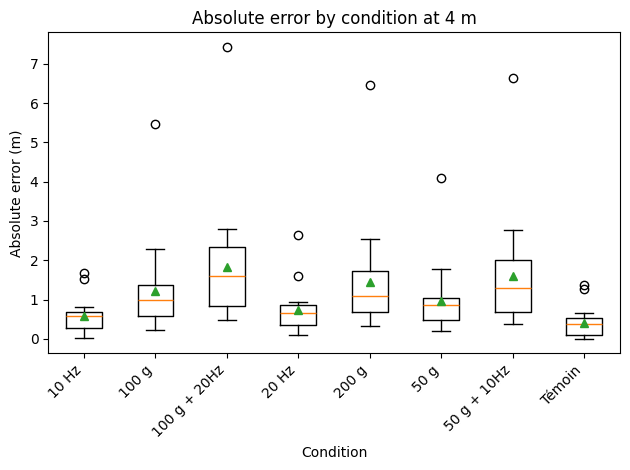

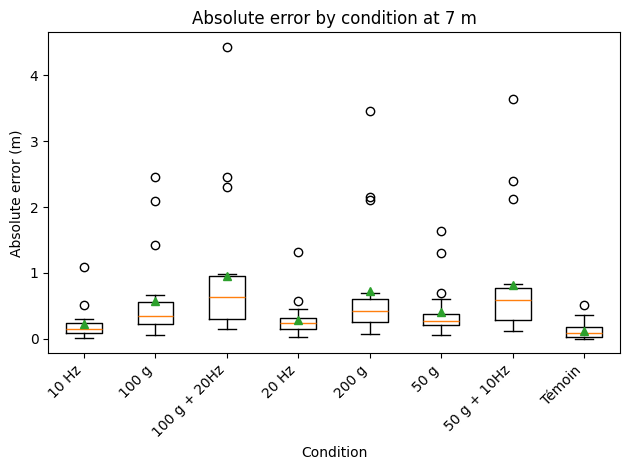

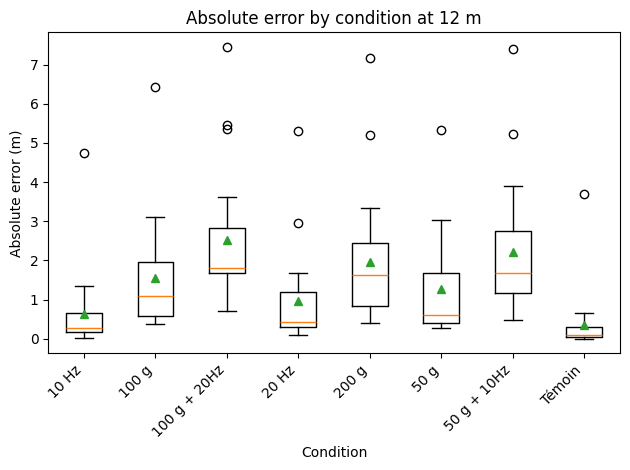

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Chargement des données
csv_path = '../data/analyse_lancers_table.csv'
df = pd.read_csv(csv_path)

# Pour chaque distance-cible, on trace un boxplot séparé
for target in sorted(df['target_distance'].unique()):
    sub = df[df['target_distance'] == target]
    conds = sorted(sub['condition'].unique())
    data = [sub.loc[sub['condition'] == cond, 'error_to_target'].values for cond in conds]

    fig, ax = plt.subplots()
    ax.boxplot(data, showmeans=True)

    # On positionne les étiquettes nous memes
    ax.set_xticklabels(conds, rotation=45, ha='right')

    ax.set_title(f"Absolute error by condition at {target} m")
    ax.set_ylabel("Absolute error (m)")
    ax.set_xlabel("Condition")

    plt.tight_layout()
    plt.show()


finalement je crée trois graphiques , un pour chaque distance cible -> avec  seaborn, je trace des boxplots de l’erreur absolue pour chacune des 8 conditions, en y ajoutant un point blanc pour la moyenne. Cela permet de voir la dispersion et l’ordre des conditions en termes de précision

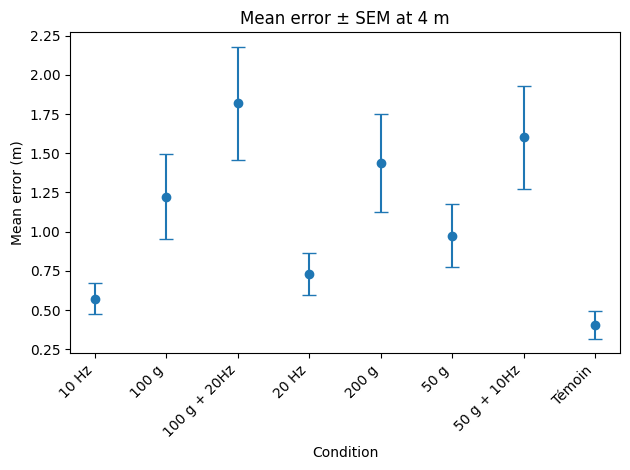

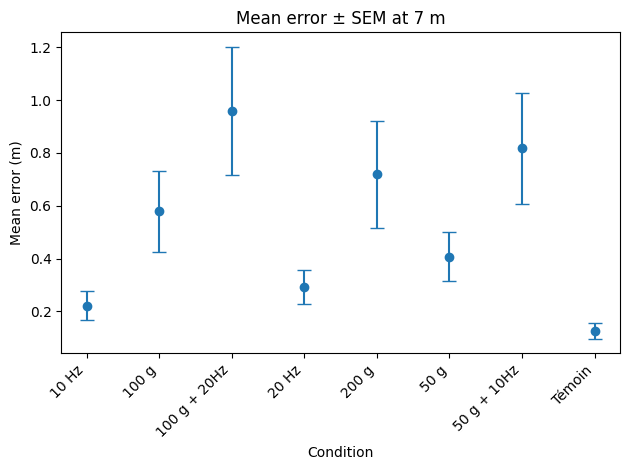

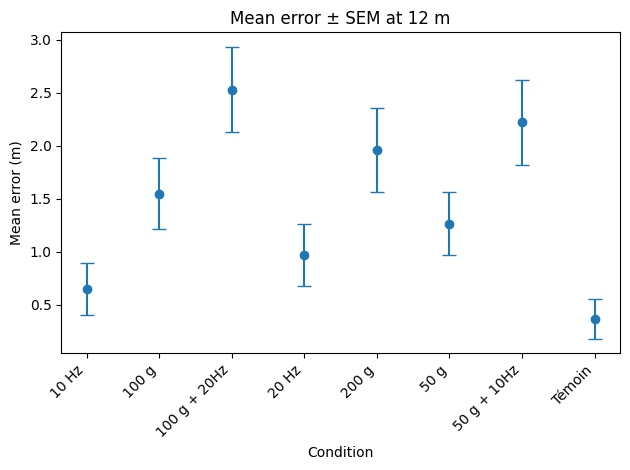

In [ ]:
#  Erreur moyenne ± SEM par condition et distance-cible 
import pandas as pd
import matplotlib.pyplot as plt

# On part du DataFrame df déjà chargé et nettoyé
# Calcul des moyennes et SEM
summary = (
    df
    .groupby(['target_distance', 'condition'])['error_to_target']
    .agg(['mean', 'sem'])
    .reset_index()
)

# Tracé d’un graphique par distance/cible
for target in sorted(summary['target_distance'].unique()):
    sub = summary[summary['target_distance'] == target]
    conds = sub['condition']
    means = sub['mean']
    sems  = sub['sem']
    
    fig, ax = plt.subplots()
    ax.errorbar(
        x=range(len(conds)),
        y=means,
        yerr=sems,
        fmt='o',
        capsize=5
    )
    ax.set_xticks(range(len(conds)))
    ax.set_xticklabels(conds, rotation=45, ha='right')
    ax.set_title(f"Mean error ± SEM at {target} m")
    ax.set_ylabel("Mean error (m)")
    ax.set_xlabel("Condition")
    plt.tight_layout()
    plt.show()
